In [14]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [15]:
# ==============================================================================
# 1. NGUỒN DỮ LIỆU (Tự động dò file) & 2. EDA NHANH
# ==============================================================================
print("--- 1. Nguồn dữ liệu & 2. EDA ---")
csv_files = glob.glob('*.csv')
if not csv_files:
    raise ValueError("Không tìm thấy file CSV nào trong thư mục!")

filename = csv_files[0] # Lấy file đầu tiên tìm thấy
print(f"Đang đọc file: {filename}")
df = pd.read_csv(filename)

print(f"\nKích thước ban đầu: {df.shape}")
print(df.info())

--- 1. Nguồn dữ liệu & 2. EDA ---
Đang đọc file: HeartDisease_Clustered.csv

Kích thước ban đầu: (302, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            302 non-null    int64  
 1   sex                            302 non-null    object 
 2   chest_pain_type                302 non-null    object 
 3   resting_blood_pressure         302 non-null    int64  
 4   cholestoral                    302 non-null    int64  
 5   fasting_blood_sugar            302 non-null    object 
 6   rest_ecg                       302 non-null    object 
 7   Max_heart_rate                 302 non-null    int64  
 8   exercise_induced_angina        302 non-null    object 
 9   oldpeak                        302 non-null    float64
 10  slope                          302 non-null    object 
 11  ves

In [16]:
# ==============================================================================
# 3. TIỀN XỬ LÝ (LÀM SẠCH CHUẨN ONLINE RETAIL/Y TẾ)
# ==============================================================================
print("\n--- 3. Làm sạch dữ liệu ---")
# 3.1 Xử lý trùng lặp (QUAN TRỌNG NHẤT)
duplicates = df.duplicated().sum()
if duplicates > 0:
    print(f"Phát hiện {duplicates} dòng trùng lặp -> Đang xóa...")
    df_clean = df.drop_duplicates()
else:
    df_clean = df.copy()

# 3.2 Xử lý Missing values (nếu có)
df_clean = df_clean.dropna()

print(f"Kích thước sau làm sạch: {df_clean.shape}")


--- 3. Làm sạch dữ liệu ---
Kích thước sau làm sạch: (302, 15)


In [17]:
# ==============================================================================
# 4. ÁP DỤNG APRIORI (TÌM LUẬT KẾT HỢP)
# ==============================================================================
print("\n--- 4. Tìm luật kết hợp (Association Rules) ---")
# Chuẩn bị dữ liệu cho luật (cần dạng phân loại/binning)
df_rules = df_clean.copy()
# Chia nhóm các biến số thực thành các khoảng (Low/Medium/High)
df_rules['age_bin'] = pd.cut(df_rules['age'], bins=[0, 45, 60, 100], labels=['Age:Young', 'Age:Middle', 'Age:Senior'])
df_rules['chol_bin'] = pd.cut(df_rules['cholestoral'], bins=[0, 200, 239, 600], labels=['Chol:OK', 'Chol:Border', 'Chol:High'])
df_rules['target_label'] = df_rules['target'].map({0: 'No Disease', 1: 'Disease'})

# Hàm tính toán thủ công (do không có thư viện mlxtend)
def calculate_rules(df, feature_cols, target_col='target_label'):
    rules = []
    total = len(df)
    for col in feature_cols:
        for val in df[col].unique():
            for target in df[target_col].unique():
                # Tính toán các chỉ số
                mask_ant = (df[col] == val)
                mask_cons = (df[target_col] == target)
                mask_both = mask_ant & mask_cons

                n_ant = mask_ant.sum()
                n_both = mask_both.sum()
                n_cons = mask_cons.sum()

                if n_ant == 0: continue

                supp = n_both / total
                conf = n_both / n_ant
                lift = conf / (n_cons / total)

                # Lọc luật có ý nghĩa (Confidence > 0.6 và Lift > 1.2)
                if conf > 0.6 and lift > 1.2:
                    rules.append({
                        'Antecedent': f"{col}={val}",
                        'Consequent': target,
                        'Lift': round(lift, 2),
                        'Conf': round(conf, 2),
                        'Support': round(supp, 2)
                    })
    return pd.DataFrame(rules).sort_values('Lift', ascending=False)

# Chạy tìm luật trên các cột phân loại
cat_features = ['sex', 'chest_pain_type', 'exercise_induced_angina', 'age_bin', 'chol_bin']
df_res_rules = calculate_rules(df_rules, cat_features)
print("Top 5 Luật kết hợp tìm được:")
print(df_res_rules.head(5).to_string(index=False))


--- 4. Tìm luật kết hợp (Association Rules) ---
Top 5 Luật kết hợp tìm được:
                      Antecedent Consequent  Lift  Conf  Support
     exercise_induced_angina=Yes No Disease  1.68  0.77     0.25
  chest_pain_type=Typical angina No Disease  1.59  0.73     0.34
 chest_pain_type=Atypical angina    Disease  1.51  0.82     0.14
chest_pain_type=Non-anginal pain    Disease  1.46  0.79     0.23
                      sex=Female    Disease  1.38  0.75     0.24



--- 5. Phân cụm & Đánh giá (Method A: Numeric Features) ---
Số cụm tối ưu (Best K): 2 (Silhouette: 0.2369)


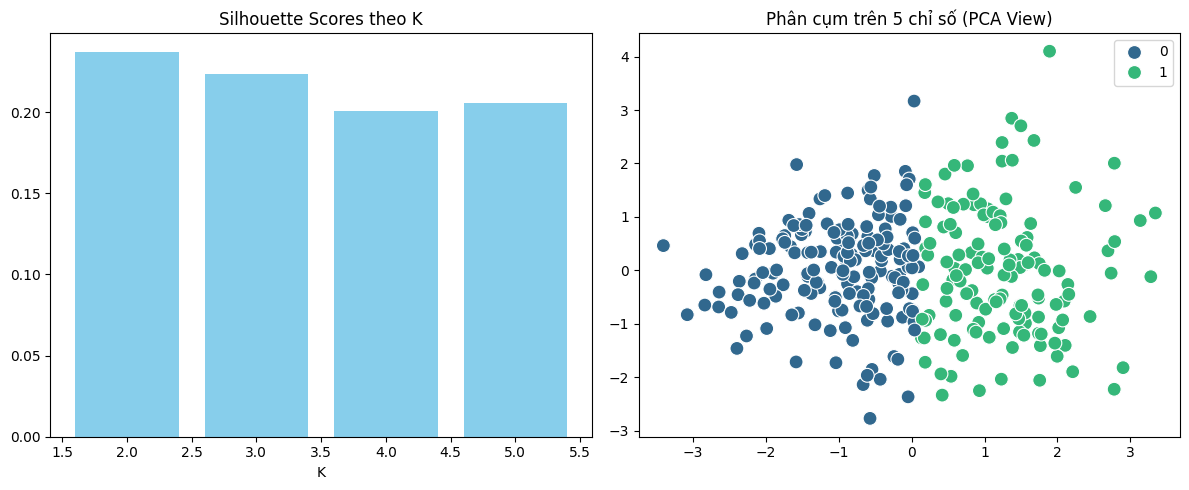


--- Tóm tắt đặc điểm từng cụm (Mean) ---
               age  resting_blood_pressure  cholestoral  Max_heart_rate  \
Cluster                                                                   
0        49.426036              125.378698   234.059172      161.420118   
1        60.766917              139.511278   262.308271      134.511278   

          oldpeak  Count  
Cluster                   
0        0.507101    169  
1        1.724060    133  

[DONE] Đã xuất file kết quả: HeartDisease_Final_Result.csv


In [19]:
# ==============================================================================
# 5. PHÂN CỤM (METHOD A: RAW NUMERIC - RFM PROXY) & ĐÁNH GIÁ
# ==============================================================================
print("\n--- 5. Phân cụm & Đánh giá (Method A: Numeric Features) ---")
# Chỉ chọn các biến số thực (Numeric) quan trọng thay thế cho RFM
rfm_cols = ['age', 'resting_blood_pressure', 'cholestoral', 'Max_heart_rate', 'oldpeak']
X = df_clean[rfm_cols]

# 5.1 Scale dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5.2 Tìm K và chạy KMeans (Helper Logic)
sil_scores = []
K_range = range(2, 6)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

best_k = K_range[np.argmax(sil_scores)]
print(f"Số cụm tối ưu (Best K): {best_k} (Silhouette: {max(sil_scores):.4f})")

# Mô hình cuối cùng
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = final_kmeans.fit_predict(X_scaled)
df_clean['Cluster'] = clusters # Gán nhãn cụm vào dữ liệu

# 5.3 Trực quan hóa (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 5))

# Plot 1: Elbow/Silhouette (Minh họa đơn giản bằng bar chart)
plt.subplot(1, 2, 1)
plt.bar(K_range, sil_scores, color='skyblue')
plt.title('Silhouette Scores theo K')
plt.xlabel('K')

# Plot 2: PCA Clusters
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis', s=100)
plt.title(f'Phân cụm trên {len(rfm_cols)} chỉ số (PCA View)')
plt.tight_layout()
plt.show()

# 5.4 Tóm tắt cụm (Cluster Profiling)
print("\n--- Tóm tắt đặc điểm từng cụm (Mean) ---")
cluster_summary = df_clean.groupby('Cluster')[rfm_cols].mean()
cluster_summary['Count'] = df_clean['Cluster'].value_counts()
print(cluster_summary)

# 5.5 Export CSV
output_filename = "HeartDisease_Final_Result.csv"
df_clean.to_csv(output_filename, index=False)
print(f"\n[DONE] Đã xuất file kết quả: {output_filename}")